# 道路交通事故受伤预测

## 导入必要的包

In [37]:
import numpy as np
import pandas as pd

# from IPython.display import display, display_html , HTML

import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA

# from sklearn.model_selection import train_test_split

# from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
# from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
# from sklearn.model_selection import train_test_split

# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')


# 为了在Jupyter Notebook中显示图片的必须配置项
%matplotlib inline
# 用兼容字体解决中文显示为方格的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

## 常量&全局变量定义

In [38]:
# 没有用的特征名列表，方便eval和test时丢弃
unusedFeatureList = []
# 各个特征最可能的值，用于填补空缺。 key为特征名，value为特征的最可能值
featureMostfreqValueDict = {}

## 函数定义

In [39]:
def countDFNull(aimDF):
    nullAmount = aimDF.isnull().sum().sum()
    print("Null数量 : ", nullAmount)
    return nullAmount

## 读取数据集

In [40]:
print("读取trainDataset")
trainDatasetDF = pd.read_csv('dataset/train.csv', header=0, index_col=None)
trainDatasetDF.Name = 'train dataset'
# print(trainDatasetDF.head(2))

print("读取evalDataset")
evalDatasetDF = pd.read_csv('dataset/val.csv', header=0, index_col=0)
evalDatasetDF.Name = 'eval dataset'
# print(evalDatasetDF.head(2))

print("读取testDataset")
testDatasetDF = pd.read_csv('dataset/test.csv', header=0, index_col=0)
testDatasetDF.Name = 'test dataset'
# print(testDatasetDF.head(2))


datasetDFList = [trainDatasetDF,evalDatasetDF,testDatasetDF]

for df in datasetDFList:
    print("DF Name : ", df.Name, "  DF Shape : ", df.shape)

读取trainDataset
读取evalDataset
读取testDataset
DF Name :  train dataset   DF Shape :  (79786, 54)
DF Name :  eval dataset   DF Shape :  (2836, 54)
DF Name :  test dataset   DF Shape :  (2836, 53)


## 数据清洗

In [41]:
topBadFeatureNumbers = 20  # 展示缺失样本最多的特征的数量，全部展示太长了

badFeatureMaxMissingSample = 500  # 若某个特征缺失的样本数量超过该值，认定为坏特征
badSampleMaxMissingFeature = 1  # 若某个样本缺失的特征超过该值，认定为坏样本

### 找出sample较少的feature

In [42]:
# 对所有特征（每一列）进行null值统计
trainFeatureNullSeries = trainDatasetDF.isnull().sum().sort_values(ascending=False)  # 降序排列
print("type : ", type(trainFeatureNullSeries))
# averageTrainFeatureNull = trainFeatureNullSeries.sum()/len(trainFeatureNullSeries)
# print("averageTrainFeatureNull : ", averageTrainFeatureNull)
trainFeatureNullDict = trainFeatureNullSeries.to_dict()
badTrainFeatureDict = {key:trainFeatureNullDict[key] for key in trainFeatureNullDict if trainFeatureNullSeries[key] > badFeatureMaxMissingSample}
print("缺失%d个以上样本的特征数量 : "%badFeatureMaxMissingSample, len(badTrainFeatureDict))
print(badTrainFeatureDict)

type :  <class 'pandas.core.series.Series'>
缺失500个以上样本的特征数量 :  13
{'lartpc': 79508, 'larrout': 79277, 'occutc': 78639, 'v2': 73891, 'v1': 14997, 'pr1': 10096, 'pr': 9672, 'circ': 4255, 'voie': 3712, 'vma': 1287, 'vosp': 1034, 'nbv': 1019, 'adr': 808}


Text(0.5, 1.0, '缺失样本数量最多的Top20特征 柱状图')

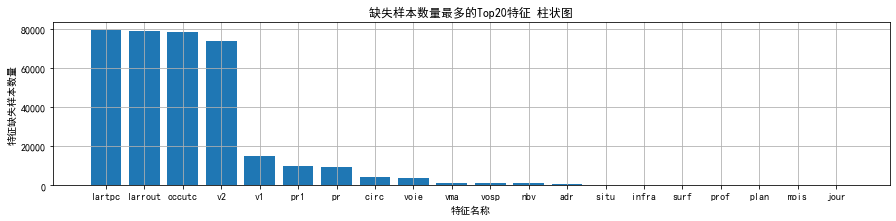

In [43]:
# 可视化展示特征，缺失样本的数量
plt.figure(figsize=(15,3))
plt.grid()
plt.bar(x=trainFeatureNullSeries.index[0:topBadFeatureNumbers], height=trainFeatureNullSeries.values[0:topBadFeatureNumbers])
plt.xlabel("特征名称")
plt.ylabel("特征缺失样本数量")
plt.title("缺失样本数量最多的Top%d特征 柱状图"%topBadFeatureNumbers)

In [44]:
# 删除选出的bad feature整列
unusedFeatureList.extend(badTrainFeatureDict.keys())
print('unusedFeatureList : ', unusedFeatureList)

trainDatasetDF.drop(columns=badTrainFeatureDict.keys(), inplace=True)
print(trainDatasetDF.shape)

unusedFeatureList :  ['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr']
(79786, 41)


type :  <class 'pandas.core.series.Series'>
{'situ': 302, 'infra': 226, 'surf': 190, 'prof': 185, 'plan': 176, 'atm': 163, 'jour': 163, 'catr': 163, 'long': 163, 'col': 163, 'lat': 163, 'int': 163, 'agg': 163, 'com': 163, 'dep': 163}


Text(0.5, 1.0, '删除坏特征后的特征缺失情况 柱状图')

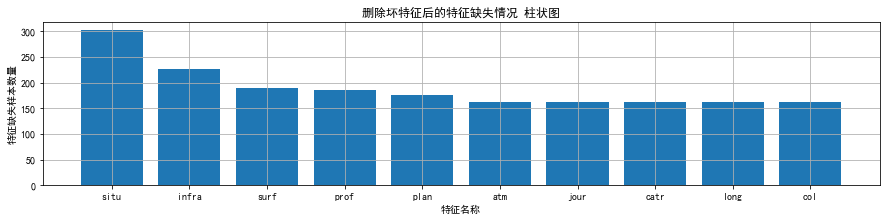

In [45]:
# 统计删除后的特征缺失情况
trainFeatureNullSeries = trainDatasetDF.isnull().sum().sort_values(ascending=False)  # 降序排列
print("type : ", type(trainFeatureNullSeries))
print(trainFeatureNullSeries.head(15).to_dict())

# 可视化展示特征，缺失样本的数量
plt.figure(figsize=(15,3))
plt.grid()
plt.bar(x=trainFeatureNullSeries.index[0:10], height=trainFeatureNullSeries.values[0:10])
plt.xlabel("特征名称")
plt.ylabel("特征缺失样本数量")
plt.title("删除坏特征后的特征缺失情况 柱状图")

### 找出feature较少的sample

In [46]:
# 对所有样本（每一行）进行null值统计
trainSampleNullSeries = trainDatasetDF.T.isnull().sum().sort_values(ascending=False) # 倒序排列
trainSampleNullDict = trainSampleNullSeries.to_dict()
print("type : ", type(trainSampleNullSeries))

badTrainSampleDict = {key:trainSampleNullDict[key] for key in trainSampleNullDict if trainSampleNullDict[key] > badSampleMaxMissingFeature}
print("缺失%d个以上特征的样本数量 : "%badSampleMaxMissingFeature, len(badTrainSampleDict))
print(badTrainSampleDict)
# averageTrainSampleNull = trainSampleNullSeries.sum()/len(trainSampleNullSeries)
# print("averageTrainSampleNull : ", averageTrainSampleNull)

type :  <class 'pandas.core.series.Series'>
缺失1个以上特征的样本数量 :  181
{14951: 19, 56986: 19, 41678: 19, 56992: 19, 56991: 19, 15726: 19, 41677: 19, 41597: 19, 39022: 19, 40418: 19, 40417: 19, 40215: 19, 48658: 19, 52159: 19, 52160: 19, 74093: 19, 78644: 19, 74094: 19, 5045: 19, 10723: 19, 41784: 19, 14926: 19, 70809: 19, 24282: 19, 59932: 19, 59931: 19, 69083: 19, 55953: 19, 10904: 19, 10903: 19, 74746: 19, 74747: 19, 14953: 19, 14952: 19, 54032: 19, 32845: 19, 37693: 19, 37692: 19, 45758: 19, 45757: 19, 37691: 19, 37690: 19, 78660: 19, 55954: 19, 31389: 19, 14925: 19, 71574: 19, 45741: 19, 58847: 19, 61454: 19, 11887: 19, 67785: 19, 67784: 19, 67783: 19, 30127: 19, 66939: 19, 61328: 19, 61005: 19, 16441: 19, 61004: 19, 61003: 19, 35970: 19, 62160: 19, 62163: 19, 48839: 19, 35969: 19, 48838: 19, 48837: 19, 58848: 19, 47717: 19, 71771: 19, 45193: 19, 67664: 19, 65857: 19, 65858: 19, 45740: 19, 45739: 19, 45738: 19, 71772: 19, 52181: 19, 52182: 19, 6642: 19, 47726: 19, 21581: 19, 21582: 19, 4

In [24]:
# 删除选出的bad sample整行
trainDatasetDF.drop(index=badTrainSampleDict.keys(), inplace=True)
print(trainDatasetDF.shape)

(79623, 41)


41


### 找出值不具有参考性的特征

In [26]:
# 特征的值的可能太多和太少都不具有参考性
tooMuchValueFeatureThreshold = 300  # 如果特征的可能的指多于该数，认定为没有参考性
tooLessValueFeatureThreshold = 2  # 如果特征的可能的指少于该数，认定为没有参考性

In [30]:
featureValueCountDict = {}
# 输出各个特征值对应的特征数量
for loopIdx, colName in enumerate(trainDatasetDF):
    tempSeries = trainDatasetDF[colName]
    tempSeriesValueCountDict = tempSeries.value_counts().to_dict()
    # print("特征", colName, "共有%d个可能值"%len(tempSeriesValueCountDict))
    featureValueCountDict[colName] = len(tempSeriesValueCountDict)

print(featureValueCountDict)

tooMuchValueFeatureList = [feature for feature in featureValueCountDict if featureValueCountDict[feature] > tooMuchValueFeatureThreshold]
tooLessValueFeatureList = [feature for feature in featureValueCountDict if featureValueCountDict[feature] < tooLessValueFeatureThreshold]

print("tooMuchValueFeatureList : ", tooMuchValueFeatureList)
print("tooLessValueFeatureList : ", tooLessValueFeatureList)

{'Num_Acc': 48304, 'jour': 31, 'mois': 12, 'an': 1, 'hrmn': 1347, 'lum': 5, 'dep': 107, 'com': 10018, 'agg': 2, 'int': 9, 'atm': 10, 'col': 8, 'lat': 46055, 'long': 46428, 'catr': 8, 'prof': 4, 'plan': 4, 'surf': 9, 'infra': 10, 'situ': 7, 'id_vehicule': 65846, 'num_veh': 27, 'place': 10, 'catu': 3, 'grav': 4, 'sexe': 2, 'an_nais': 103, 'trajet': 8, 'secu1': 11, 'secu2': 11, 'secu3': 10, 'locp': 11, 'actp': 13, 'etatp': 4, 'senc': 5, 'catv': 31, 'obs': 19, 'obsm': 8, 'choc': 11, 'manv': 28, 'motor': 8}
tooMuchValueFeatureList :  ['Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule']
tooLessValueFeatureList :  ['an']


In [32]:
unusedFeatureList.extend(tooMuchValueFeatureList)
unusedFeatureList.extend(tooLessValueFeatureList)

print("unusedFeatureList : ", unusedFeatureList)

unusedFeatureList :  ['Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an']


In [36]:
trainDatasetDF.drop(columns=unusedFeatureList, inplace=True)
print(trainDatasetDF.shape)

(79623, 34)


In [49]:
for featureName in trainDatasetDF:
    featureType = trainDatasetDF[featureName].dtype
    print(featureName, featureType, featureValueCountDict[featureName])

# 查看类型为object的feature

jour float64 31
mois float64 12
lum float64 5
dep object 107
agg float64 2
int float64 9
atm float64 10
col float64 8
catr float64 8
prof float64 4
plan float64 4
surf float64 9
infra float64 10
situ float64 7
num_veh object 27
place int64 10
catu int64 3
grav int64 4
sexe int64 2
an_nais int64 103
trajet int64 8
secu1 int64 11
secu2 int64 11
secu3 int64 10
locp int64 11
actp object 13
etatp int64 4
senc int64 5
catv int64 31
obs int64 19
obsm int64 8
choc int64 11
manv int64 28
motor int64 8


### 统计清洗后空值数量

In [12]:
nullAfterClean = trainDatasetDF.isnull().sum().sum()
print(nullAfterClean)

264


## 缺失值填充 

In [29]:
trainImputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [30]:
trainDatasetDF = trainImputer.fit_transform(trainDatasetDF)

In [41]:
nullAfterClean = countDFNull(trainDatasetDF)
print(nullAfterClean)

Null数量 :  264
264


## 数据重采样 

### 查看训练集标签分布

In [26]:
countTrainDatasetLabel = trainDatasetDF['grav'].value_counts()
print(countTrainDatasetLabel)
maxTrainLabelAmount = countTrainDatasetLabel.max()
print(maxTrainLabelAmount)

1    33205
4    31839
3    12505
2     2074
Name: grav, dtype: int64
33205


<BarContainer object of 4 artists>

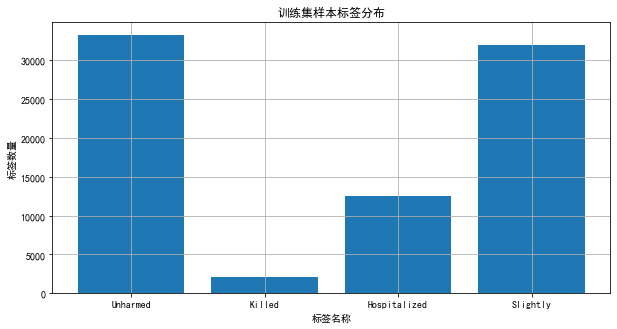

In [24]:
plt.figure(figsize=(10,5))
plt.title("训练集样本标签分布")
plt.xlabel('标签名称')
plt.ylabel('标签数量')
plt.grid()
plt.xticks(labels=['Unharmed','Killed','Hospitalized','Slightly'], ticks=[1,2,3,4])
plt.bar(x=countTrainDatasetLabel.index, height=countTrainDatasetLabel.values)

In [25]:
# 1. Unharmed # 2. Killed # 3. Injured hospitalized # 4. Slightly injured 
trainUnharmedDF = trainDatasetDF.groupby('grav').get_group(1)
trainKilledDF = trainDatasetDF.groupby('grav').get_group(2)
trainHospitalizedDF = trainDatasetDF.groupby('grav').get_group(3)
trainSlightlyDF = trainDatasetDF.groupby('grav').get_group(4)

print(trainUnharmedDF.shape)
print(trainKilledDF.shape)
print(trainHospitalizedDF.shape)
print(trainSlightlyDF.shape)

(33205, 41)
(2074, 41)
(12505, 41)
(31839, 41)


In [29]:
overSampleTrainUnharmedDF = trainUnharmedDF
overSampleTrainKilledDF = trainKilledDF.sample(n=maxTrainLabelAmount, replace=True, random_state=42)
overSampleTrainHospitalizedDF = trainHospitalizedDF.sample(n=maxTrainLabelAmount, replace=True, random_state=42)
overSampleTrainSlightlyDF = trainSlightlyDF.sample(n=maxTrainLabelAmount, replace=True, random_state=42)

print(len(overSampleTrainUnharmedDF))
print(len(overSampleTrainKilledDF))
print(len(overSampleTrainHospitalizedDF))
print(len(overSampleTrainSlightlyDF))

overSampleTrainDatasetDF = pd.concat([overSampleTrainUnharmedDF, overSampleTrainKilledDF, overSampleTrainHospitalizedDF, overSampleTrainSlightlyDF])

print(overSampleTrainDatasetDF.info())

33205
33205
33205
33205
<class 'pandas.core.frame.DataFrame'>
Int64Index: 132820 entries, 1 to 48653
Data columns (total 41 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      132820 non-null  int64  
 1   jour         132820 non-null  float64
 2   mois         132820 non-null  float64
 3   an           132820 non-null  float64
 4   hrmn         132820 non-null  float64
 5   lum          132820 non-null  float64
 6   dep          132820 non-null  object 
 7   com          132820 non-null  object 
 8   agg          132820 non-null  float64
 9   int          132820 non-null  float64
 10  atm          132820 non-null  float64
 11  col          132820 non-null  float64
 12  lat          132820 non-null  float64
 13  long         132820 non-null  float64
 14  catr         132820 non-null  float64
 15  prof         132734 non-null  float64
 16  plan         132747 non-null  float64
 17  surf         132720 non-null  float64
 18  i

## 模型训练

In [32]:
trainXDF = trainDatasetDF.drop(columns=['grav'])
trainYDF = trainDatasetDF.loc[:, 'grav']
evalXDF = evalDatasetDF.drop(columns=['grav'])
evalYDF = evalDatasetDF.loc[:, 'grav']

0        4
1        1
2        1
3        4
4        4
        ..
79781    1
79782    4
79783    1
79784    4
79785    4
Name: grav, Length: 79623, dtype: int64


In [ ]:
preprocessorPipeline = make_pipeline()

randomForestPipeline = make_pipeline(preprocessorPipeline, )
adaBoostPipeline = make_pipeline(preprocessorPipeline, )



<built-in method keys of dict object at 0x000001F705223200>
